<a href="https://colab.research.google.com/github/comchem/Pytorch_DeepLearning_Tutorials/blob/master/Sec6-RNN_%26_TimeSeries/7-RNN_Image_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
train_dataset = torchvision.datasets.MNIST(
    root='.', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(
    root='.', train=False, transform=transforms.ToTensor(), download=True)

batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
### Build the model
class RNN(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
        super(RNN, self).__init__()
        self.D = n_inputs
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers
        
        self.rnn = nn.LSTM(
          input_size = self.D,
          hidden_size = self.M,
          num_layers = self.L,
          batch_first = True)
    
        self.fc = nn.Linear(self.M, self.K)
    
    def forward(self, X):
        # initial hidden states
        h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        c0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        
        # get RNN unit output
        # out is of size (N, T, M)
        # 2nd return value is hidden states at each hidden layer
        # we don't need those now
        out, _ = self.rnn(X, (h0, c0))
        
        # we only want h(T) at the final time step
        # N x M --> N x K
        out = self.fc(out[:, -1, :])
        return out

In [4]:
model = RNN(28, 128, 2, 10)

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda:0


RNN(
  (rnn): LSTM(28, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=10, bias=True)
)

In [9]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [12]:
# Train the model
n_epochs = 20

# Stuff to store
train_losses = np.zeros(n_epochs)
test_losses = np.zeros(n_epochs)

for it in range(n_epochs):
  t0 = datetime.now()
  train_loss = []
  for inputs, targets in train_loader:
    # move data to GPU
    inputs, targets = inputs.to(device), targets.to(device)

    # reshape the input
    inputs = inputs.view(-1, 28, 28)

    # zero the parameter gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # Backward and optimize
    loss.backward()
    optimizer.step()

    train_loss.append(loss.item())
    
  # Get train loss and test loss
  train_loss = np.mean(train_loss)   # a little misleading

  test_loss = []
  for inputs, targets in test_loader:
     inputs, targets = inputs.to(device), targets.to(device)
     inputs = inputs.view(-1, 28, 28)
     outputs = model(inputs)
     loss = criterion(outputs, targets)
     test_loss.append(loss.item())
  test_loss = np.mean(test_loss)

  # Save losses
  train_losses[it] = train_loss
  test_losses[it] = test_loss

  dt = datetime.now() - t0      
  print(f'Epoch {it+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Duration: {dt}')

Epoch 1/20, Train Loss: 0.5638, Test Loss: 0.1543
Epoch 2/20, Train Loss: 0.1340, Test Loss: 0.1008
Epoch 3/20, Train Loss: 0.0919, Test Loss: 0.0804
Epoch 4/20, Train Loss: 0.0671, Test Loss: 0.0695
Epoch 5/20, Train Loss: 0.0525, Test Loss: 0.0631
Epoch 6/20, Train Loss: 0.0430, Test Loss: 0.0569
Epoch 7/20, Train Loss: 0.0410, Test Loss: 0.0502
Epoch 8/20, Train Loss: 0.0356, Test Loss: 0.0481
Epoch 9/20, Train Loss: 0.0307, Test Loss: 0.0400
Epoch 10/20, Train Loss: 0.0263, Test Loss: 0.0415
Epoch 11/20, Train Loss: 0.0247, Test Loss: 0.0422
Epoch 12/20, Train Loss: 0.0221, Test Loss: 0.0372
Epoch 13/20, Train Loss: 0.0193, Test Loss: 0.0345
Epoch 14/20, Train Loss: 0.0192, Test Loss: 0.0399
Epoch 15/20, Train Loss: 0.0169, Test Loss: 0.0437
Epoch 16/20, Train Loss: 0.0164, Test Loss: 0.0474
Epoch 17/20, Train Loss: 0.0170, Test Loss: 0.0371
Epoch 18/20, Train Loss: 0.0113, Test Loss: 0.0399
Epoch 19/20, Train Loss: 0.0138, Test Loss: 0.0421
Epoch 20/20, Train Loss: 0.0132, Test Lo

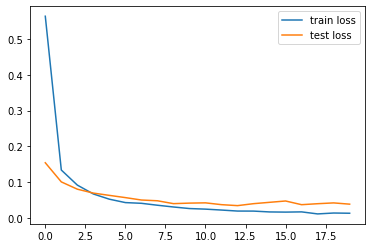

In [13]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [15]:
# Accuracy

n_correct = 0.
n_total = 0.
for inputs, targets in train_loader:
    # move data to GPU
    inputs, targets = inputs.to(device), targets.to(device)

    # reshape the input
    inputs = inputs.view(-1, 28, 28)
    
    # Forward pass
    outputs = model(inputs)
    #print(outputs.shape)
    
    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)      # _ : result value, predictions : max로 선택된 Digit index (logit function)
    # print(_, predictions)
    
    # update counts
    n_correct += (predictions == targets).sum().item()   # item : sum까지만 하면 출력이 tensor로 표현되므로 합산만 뽑아냄
    n_total += targets.shape[0]
    
train_acc = n_correct / n_total


n_correct = 0.
n_total = 0.
for inputs, targets in test_loader:
    # move data to GPU
    inputs, targets = inputs.to(device), targets.to(device)
    
    # reshape the input
    inputs = inputs.view(-1, 28, 28)
    
    # Forward pass
    outputs = model(inputs)
    
    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)      # _ : result value, predictions : max로 선택된 Digit index (logit function)
    
    # update counts
    n_correct += (predictions == targets).sum().item()   # item : sum까지만 하면 출력이 tensor로 표현되므로 합산만 뽑아냄
    n_total += targets.shape[0]
    
test_acc = n_correct / n_total
print(f'Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}')

Train acc: 0.9980, Test acc: 0.9902


In [16]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                         normalize=False,
                         title='Confusion matrix',
                         cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting 'normalize=True'.
    """
    if normalize:
        cm = dm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)    # color 부여
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i,j], fmt),
                horizontalalignment='center',
                color='white' if cm[i,j] > thresh else 'black')
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
  # Do these results make sense?
  # It's easy to confuse 9 <--> 4, 9 <--> 7, 2 <--> 7, etc.

Confusion matrix, without normalization
[[ 976    0    0    0    0    0    3    1    0    0]
 [   1 1131    1    1    0    0    0    0    1    0]
 [   0    1 1026    1    0    0    1    2    1    0]
 [   0    0    4 1004    0    0    0    1    1    0]
 [   0    0    0    0  970    0    5    1    1    5]
 [   1    0    4    5    0  876    3    0    2    1]
 [   3    2    0    0    0    1  951    0    1    0]
 [   1    3    6    0    0    0    0 1014    1    3]
 [   0    0    2    2    0    1    2    3  964    0]
 [   0    0    1    2    9    0    0    3    4  990]]


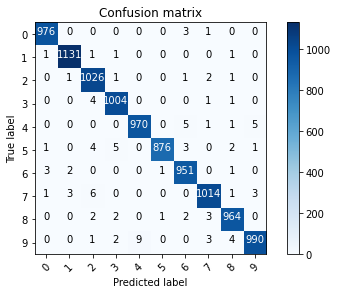

In [17]:
# get all predictions in an array and plot confusion matrix

x_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()
p_test = np.array([])                   # p_test : prediction test

for inputs, targets in test_loader:
    # move data to GPU
    inputs = inputs.to(device)

    # reshape the input
    inputs = inputs.view(-1, 28, 28)

    # Forward pass
    outputs = model(inputs)
    
    # Get prediction
    _, predictions = torch.max(outputs, 1)  
    
    # update p_test
    p_test = np.concatenate((p_test, predictions.cpu().numpy()))   # concatenate : 여러개의 array를 붙임
    #print(p_test)
    #p_test2 = np.array(predictions.cpu().numpy())    
    # p_test2와 같이 array를 바로 감쌀수도 있으나, 그러면 concatenate 처럼 For loop 동안에 발생한 모든 array를 붙일 수 없음
    #print(p_test2)
    
cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))